In [1]:
import pandas as pd
import pyarrow.parquet as pq # Used to read the data
import os 
import numpy as np
from tensorflow.keras.layers import * # Keras is the most friendly Neural Network library, this Kernel use a lot of layers classes
from tensorflow.keras.models import Model
from tqdm import tqdm # Processing time measurement
from sklearn.model_selection import train_test_split 
from tensorflow.keras import backend as K # The backend give us access to tensorflow operations and allow us to create the Attention class
from tensorflow.keras import optimizers # Allow us to access the Adam class to modify some parameters
from sklearn.model_selection import GridSearchCV, StratifiedKFold # Used to use Kfold to train our model
from tensorflow.keras.callbacks import * # This object helps the model to train in a smarter way, avoiding overfitting

path = r'C:\Users\user\Desktop\FYP\kaggle'

In [2]:
# select how many folds will be created
N_SPLITS = 5
# it is just a constant with the measurements data size
sample_size = 800000

In [3]:
epsilon = K.epsilon()
def matthews_correlation(y_true, y_pred, K=K):
    '''Calculates the Matthews correlation coefficient measure for quality
    of binary classification problems.
    '''
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + epsilon)

In [4]:
df_train = pd.read_csv(path+'/metadata_train.csv')
df_train = df_train.set_index(['id_measurement', 'phase'])
df_train.head()

signal_id  target
id_measurement phase                   
0              0              0       0
               1              1       0
               2              2       0
1              0              3       1
               1              4       1

In [5]:
# in other notebook I have extracted the min and max values from the train data, the measurements
max_num = 127
min_num = -128

In [6]:
#data standardization to -1,1
def min_max_transf(ts, min_data, max_data, range_needed=(-1,1)):
    if min_data < 0:
        ts_std = (ts + abs(min_data)) / (max_data + abs(min_data))
    else:
        ts_std = (ts - min_data) / (max_data - min_data)
    if range_needed[0] < 0:    
        return ts_std * (range_needed[1] + abs(range_needed[0])) + range_needed[0]
    else:
        return ts_std * (range_needed[1] - range_needed[0]) + range_needed[0]

In [7]:
def transform_ts(ts, n_dim=160, min_max=(-1,1)):
    # convert data into -1 to 1
    ts_std = min_max_transf(ts, min_data=min_num, max_data=max_num)
    # bucketsize, 5000 in this case (800000 / 160)
    bucket_size = int(sample_size / n_dim)
    # new_ts will be the container of the new data
    new_ts = []
    # iterate until 800,000
    for i in range(0, sample_size, bucket_size):
        # cut each bucket to ts_range
        ts_range = ts_std[i:i + bucket_size]
        # calculate each feature
        mean = ts_range.mean()
        std = ts_range.std() # standard deviation
        std_top = mean + std # BW1
        std_bot = mean - std # BW2
        percentil_calc = np.percentile(ts_range, [0, 1, 25, 50, 75, 99, 100]) #percentiles
        max_range = percentil_calc[-1] - percentil_calc[0] 
        relative_percentile = percentil_calc - mean 
        #adding all feautres into an array
        new_ts.append(np.concatenate([np.asarray([mean, std, std_top, std_bot, max_range]),percentil_calc, relative_percentile]))
    return np.asarray(new_ts)

In [8]:
def prep_data(start, end):
    praq_train = pq.read_pandas(path+'/train.parquet', columns=[str(i) for i in range(start, end)]).to_pandas()
    X = []
    y = []
    # it is divided by 3 because for each id_measurement there are 3 id_signal, and the start/end parameters are id_signal
    for id_measurement in tqdm(df_train.index.levels[0].unique()[int(start/3):int(end/3)]):
        X_signal = []
        # for each phase of the signal
        for phase in [0,1,2]:
            # extract from df_train both signal_id and target to compose the new data sets
            signal_id, target = df_train.loc[id_measurement].loc[phase]
            if phase == 0:
                y.append(target)
            # extract and transform data into sets of features
            X_signal.append(transform_ts(praq_train[str(signal_id)]))
        # concatenate all the 3 phases in one matrix
        X_signal = np.concatenate(X_signal, axis=1)
        # add the data to X
        X.append(X_signal)
    X = np.asarray(X)
    y = np.asarray(y)
    return X, y

In [9]:
#dividing total train_df size into 2 pieces
X = []
y = []
def load_all():
    total_size = len(df_train)
    for ini, end in [(0, int(total_size/2)), (int(total_size/2), total_size)]:
        X_temp, y_temp = prep_data(ini, end)
        X.append(X_temp)
        y.append(y_temp)
load_all()
X = np.concatenate(X)
y = np.concatenate(y)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:30<00:00,  6.66it/s]


In [12]:
# X.shape[0] is the number of id_measuremts contained in train data
# X.shape[1] is the number of chunks resultant of the transformation, each of this date enters in the LSTM serialized
# X.shape[3] is the number of features multiplied by the number of phases (3)
print(X.shape, y.shape)
np.save(path+"/X_feat.npy",X)
np.save(path+"/y_feat.npy",y)

(2000, 160, 57) (2000,)


In [13]:
import numpy as np
X = np.load(path+"/X_feat.npy")
y = np.load(path+"/y_feat.npy")

In [ ]:
#X.shape[0],X.shape[1],X.shape[2]

In [14]:
import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf


try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        outputs = Add()([outputs, q])
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn

def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask

class Encoder():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, \
                layers=6, dropout=0.1, pos_emb=None):
        self.pos_layer = pos_emb
        self.dropout = Dropout(dropout)
        self.layers = [EncoderLayer(d_model, d_inner_hid, n_head, d_k, d_v, dropout) for _ in range(layers)]
        
    def __call__(self, src_seq, src_pos, return_att=False, active_layers=999):
        x = src_seq
        if src_pos is not None:
            pos = self.pos_layer(src_pos)
            x = Add()([x, pos])
        x = self.dropout(x)
        if return_att: atts = []
        # mask = Lambda(lambda x:GetPadMask(x, x))(src_seq)
        mask = None
        for enc_layer in self.layers[:active_layers]:
            x, att = enc_layer(x, mask)
            if return_att: atts.append(att)
        return (x, atts) if return_att else x


class Transformer():
    def __init__(self, len_limit, d_model=X.shape[-1], \
              d_inner_hid=512, n_head=8, d_k=64, d_v=64, layers=2, dropout=0.1, \
              share_word_emb=False, **kwargs):
        self.name = 'Transformer'
        self.len_limit = len_limit
        self.src_loc_info = True
        self.d_model = d_model
        d_emb = d_model

        pos_emb = Embedding(len_limit, d_emb, trainable=False, \
                            weights=[GetPosEncodingMatrix(len_limit, d_emb)])

        self.encoder = Encoder(d_model, d_inner_hid, n_head, d_k, d_v, layers, dropout, \
                            pos_emb=pos_emb)

        
    def get_pos_seq(self, x):
        pos = K.cumsum(K.ones_like(x[...,0], 'int32'), 1)
        return pos

    def compile(self, active_layers=999):
        src_seq = Input(shape=(X.shape[1],X.shape[2]))
        src_pos = Lambda(self.get_pos_seq)(src_seq)
        if not self.src_loc_info: src_pos = None

        x = self.encoder(src_seq, src_pos, active_layers=active_layers)
        x = GlobalAveragePooling1D()(x)
#         x = concatenate([GlobalMaxPool1D()(x),GlobalAveragePooling1D()(x)])
#         print(x.shape)
#         x = Reshape((X.shape[1]*X.shape[2],))(x)
        outp = Dense(1, activation="sigmoid")(x)

        self.model = Model(inputs=src_seq, outputs=outp)
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[matthews_correlation])

In [15]:
#5 folds
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, y))
preds_val = []
y_val = []

for idx, (train_idx, val_idx) in enumerate(splits):
    K.clear_session()
    print("Beginning fold {}".format(idx+1))
    train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
 
    model = Transformer(train_X.shape[1]+1, layers=1,d_inner_hid=256)
    model.compile()
    model = model.model
    
    # This checkpoint helps to avoid overfitting.
    ckpt = ModelCheckpoint('weights_{}.h5'.format(idx), save_best_only=True, save_weights_only=True, verbose=1, monitor='val_matthews_correlation', mode='max')
    # Train
    history = model.fit(train_X, train_y, batch_size=128, epochs=100, validation_data=(val_X, val_y), callbacks=[ckpt])
    model.load_weights('weights_{}.h5'.format(idx))
    preds_val.append(model.predict(val_X, batch_size=512))
    y_val.append(val_y)

   
preds_val = np.concatenate(preds_val)[...,0]
y_val = np.concatenate(y_val)
preds_val.shape, y_val.shape

Beginning fold 1
Epoch 1/100
13/13 [==============================] - 13s 859ms/step - loss: 0.3472 - matthews_correlation: -0.0105 - val_loss: 0.2394 - val_matthews_correlation: 0.0000e+00

Epoch 00001: val_matthews_correlation improved from -inf to 0.00000, saving model to weights_0.h5
Epoch 2/100
13/13 [==============================] - 11s 828ms/step - loss: 0.2516 - matthews_correlation: 0.0000e+00 - val_loss: 0.2406 - val_matthews_correlation: 0.0000e+00

Epoch 00002: val_matthews_correlation did not improve from 0.00000
Epoch 3/100
13/13 [==============================] - 11s 832ms/step - loss: 0.2374 - matthews_correlation: 0.0000e+00 - val_loss: 0.2307 - val_matthews_correlation: 0.0000e+00

Epoch 00003: val_matthews_correlation did not improve from 0.00000
Epoch 4/100
13/13 [==============================] - 11s 811ms/step - loss: 0.2317 - matthews_correlation: 0.0000e+00 - val_loss: 0.2246 - val_matthews_correlation: 0.0000e+00

Epoch 00004: val_matthews_correlation did not 

((2000,), (2000,))

In [16]:
def threshold_search(y_true, y_proba):
    best_threshold = 0
    best_score = 0
    for threshold in tqdm([i * 0.01 for i in range(100)]):
        score = matthews_correlation(y_true, (y_proba > threshold).astype(np.float64),K=np)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'matthews_correlation': best_score}
    print(search_result)
    return search_result

In [17]:
best_threshold = threshold_search(y_val, preds_val)['threshold']

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 8331.62it/s]

{'threshold': 0.49, 'matthews_correlation': 0.6659999361045441}


In [18]:
%%time

meta_test = pd.read_csv(path+'/metadata_test.csv')

Wall time: 28 ms


In [19]:
meta_test = meta_test.set_index(['signal_id'])
meta_test.head()

,id_measurement,phase
signal_id,,
8712,2904,0
8713,2904,1
8714,2904,2
8715,2905,0
8716,2905,1


In [25]:
%%time
first_sig = meta_test.index[0]
n_parts = 10
max_line = len(meta_test)
part_size = int(max_line / n_parts)
last_part = max_line % n_parts
print(first_sig, n_parts, max_line, part_size, last_part, n_parts * part_size + last_part)

start_end = [[x, x+part_size] for x in range(first_sig, max_line + first_sig, part_size)]
start_end = start_end[:-1] + [[start_end[-1][0], start_end[-1][0] + last_part]]
print(start_end)
X_test = []

for start, end in start_end:
    subset_test = pq.read_pandas(path+'/test.parquet', columns=[str(i) for i in range(start, end)]).to_pandas()
    for i in tqdm(subset_test.columns):
        id_measurement, phase = meta_test.loc[int(i)]
        subset_test_col = subset_test[i]
        subset_trans = transform_ts(subset_test_col)
        X_test.append([i, id_measurement, phase, subset_trans])

8712 10 20337 2033 7 20337
[[8712, 10745], [10745, 12778], [12778, 14811], [14811, 16844], [16844, 18877], [18877, 20910], [20910, 22943], [22943, 24976], [24976, 27009], [27009, 29042], [29042, 29049]]


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.46it/s]

Wall time: 25min 19s


In [26]:
X_test_input = np.asarray([np.concatenate([X_test[i][3],X_test[i+1][3], X_test[i+2][3]], axis=1) for i in range(0,len(X_test), 3)])
np.save(path+"/X_test_feat.npy",X_test_input)
X_test_input.shape

(6779, 160, 57)

In [27]:

X_test_input = np.load(path+"/X_test_feat.npy")

In [28]:
submission = pd.read_csv(path+'/sample_submission.csv')
print(len(submission))
submission.tail()

20337


,signal_id,target
20332,29044,0
20333,29045,0
20334,29046,0
20335,29047,0
20336,29048,0


In [29]:
preds_test = []
for i in range(N_SPLITS):
    model.load_weights('weights_{}.h5'.format(i))
    pred = model.predict(X_test_input, batch_size=300, verbose=1)
    pred_3 = []
    for pred_scalar in pred:
        for i in range(3):
            pred_3.append(pred_scalar)
    preds_test.append(pred_3)


23/23 [==============================] - 10s 441ms/step


In [30]:
preds_test = (np.squeeze(np.mean(preds_test, axis=0)) > best_threshold).astype(np.int)
preds_test.shape

C:\Users\user\AppData\Local\Temp/ipykernel_11656/4056328014.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  preds_test = (np.squeeze(np.mean(preds_test, axis=0)) > best_threshold).astype(np.int)


(20337,)

In [32]:
submission['target'] = preds_test
submission.to_csv(path+'/results_of_Test.csv', index=False)
submission.head()

,signal_id,target
0,8712,0
1,8713,0
2,8714,0
3,8715,0
4,8716,0


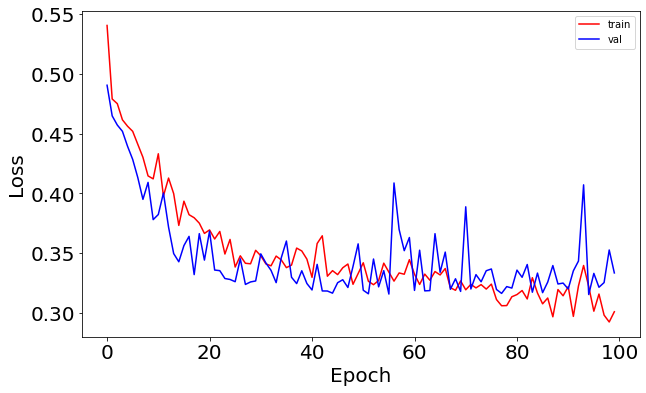

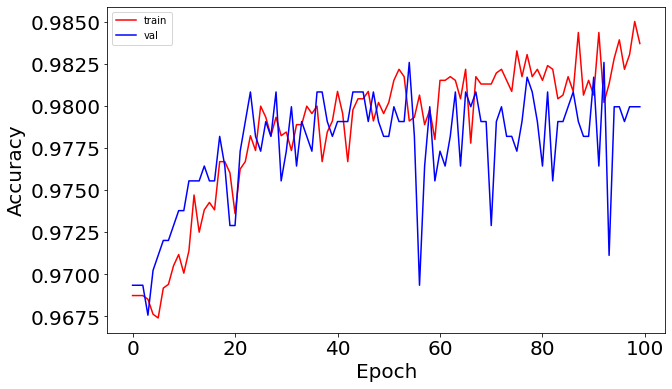

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

C:\Users\user\AppData\Local\Temp/ipykernel_11656/2902786759.py:15: RuntimeWarning: invalid value encountered in sqrt
  ax.plot(np.sqrt(history.history['val_matthews_correlation']), 'r', label='train')


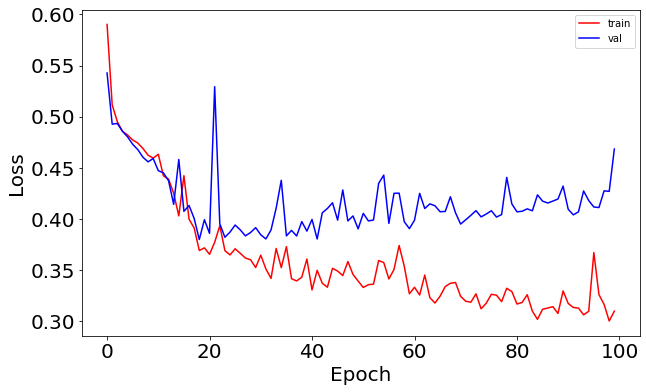

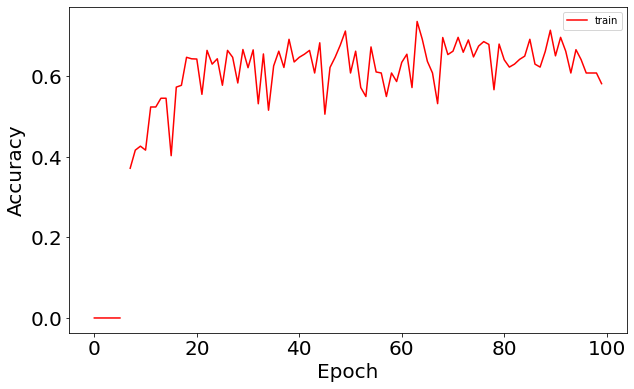

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(history.history['val_matthews_correlation']), 'r', label='train')
#ax.plot(np.sqrt(history.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)